##Importing the required modules

In [1]:
from google.colab import  drive
drive.mount('./gdrive', force_remount=True)
%cd '/content/gdrive/MyDrive/EVA S9/EVA/S10'

Mounted at ./gdrive
/content/gdrive/MyDrive/EVA S9/EVA/S10


In [2]:
import torch
import torchvision
from torch import optim
from torchsummary import summary
from matplotlib import pyplot as plt

In [3]:
!pip install -U albumentations

Requirement already up-to-date: albumentations in /usr/local/lib/python3.6/dist-packages (0.5.2)


In [4]:
import albumentations as A
from utils import DataProcessing
from regularizations import Regularizations
from model import *
from graphs import Graphs
from train import *
from test import *
from AlbumentationTransformations import  AlbumentationTransforms as AT
from albumentations import pytorch
from GradCam import *
from LR_Finder import LRFinder

## Maintaining Reproducability

In [5]:
torch.manual_seed(1)
torch.backends.cudnn.deterministic = True

##Loading the Dataset, performing image transformations and loading the DataLoader

In [6]:
data = DataProcessing('CIFAR10')


In [7]:
train_set = data.Dataset('./Data', True, True, AT([A.Cutout(),A.HorizontalFlip(), A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), A.pytorch.ToTensor()]))
test_set = data.Dataset('./Data', False, True, AT([A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)), A.pytorch.ToTensor()]))


Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_set.classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [9]:
train_set[0]

(tensor([[[-0.5373, -0.6627, -0.6078,  ...,  0.2392,  0.1922,  0.1608],
          [-0.8745, -1.0000, -0.8588,  ..., -0.0353, -0.0667, -0.0431],
          [-0.8039, -0.8745, -0.6157,  ..., -0.0745, -0.0588, -0.1451],
          ...,
          [ 0.6314,  0.5765,  0.5529,  ...,  0.2549, -0.5608, -0.5843],
          [ 0.4118,  0.3569,  0.4588,  ...,  0.4431, -0.2392, -0.3490],
          [ 0.3882,  0.3176,  0.4039,  ...,  0.6941,  0.1843, -0.0353]],
 
         [[-0.5137, -0.6392, -0.6235,  ...,  0.0353, -0.0196, -0.0275],
          [-0.8431, -1.0000, -0.9373,  ..., -0.3098, -0.3490, -0.3176],
          [-0.8118, -0.9451, -0.7882,  ..., -0.3412, -0.3412, -0.4275],
          ...,
          [ 0.3333,  0.2000,  0.2627,  ...,  0.0431, -0.7569, -0.7333],
          [ 0.0902, -0.0353,  0.1294,  ...,  0.1608, -0.5137, -0.5843],
          [ 0.1294,  0.0118,  0.1137,  ...,  0.4431, -0.0745, -0.2784]],
 
         [[-0.5059, -0.6471, -0.6627,  ..., -0.1529, -0.2000, -0.1922],
          [-0.8431, -1.0000,

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


'truck'

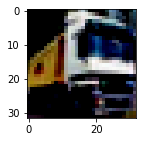

In [10]:
plt.figure(figsize=(2,2))
plt.imshow(np.transpose(train_set[1][0],(1,2,0)))
train_set.classes[train_set[1][1]]


In [11]:
train_loader = data.DataLoader(train_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)
test_loader = data.DataLoader(test_set, batch_size=64, shuffle=True, num_workers=4, pin_memory=True)

## Taking a sneak peek at the dataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


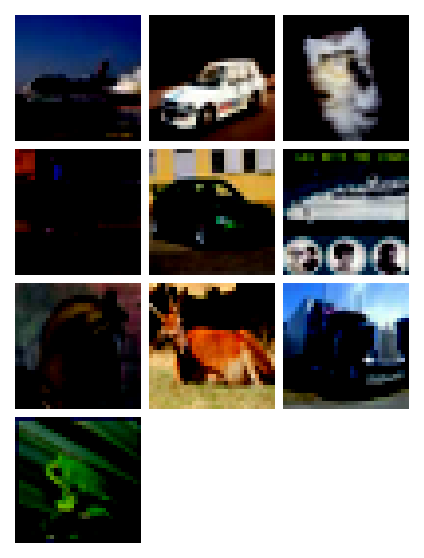

['ship', 'automobile', 'cat', 'horse', 'automobile', 'ship', 'horse', 'deer', 'truck', 'frog']


In [12]:
plt.figure(figsize=(10,10))
batch = next(iter(test_loader))
images, labels = batch
image, label = [],[]
for i in range(10):
  image.append(images[i])
  label.append(test_set.classes[labels[i]])

grid = torchvision.utils.make_grid(image, nrow=3, pad_value=1.0)
plt.imshow(np.transpose(grid, (1,2,0)))
plt.axis('off')
plt.show()
print(label)


## Viewing the parameter count used in the model

In [13]:
use_cuda = torch.cuda.is_available() # check if GPU available
device = torch.device("cuda" if use_cuda else "cpu") # use cpu if gpu is not available
model = ResNet18().to(device) 
summary(model, input_size=(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [14]:
criterion = nn.CrossEntropyLoss()
optimiser = optim.SGD(model.parameters(), lr=0.00001,momentum=0.9)
lr_finder = LRFinder(model, optimiser, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=1, num_iter=600 ,step_mode="exp")


Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 4.78E-03


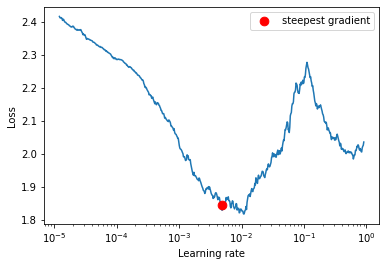

(<matplotlib.axes._subplots.AxesSubplot at 0x7fee23029dd8>,
 0.004780416935472743)

In [15]:
lr_finder.plot()

##Loading the object for different regularizations

In [16]:
Best_lr = lr_finder.history['lr'][lr_finder.history['loss'].index(lr_finder.best_loss)]

In [17]:
lr_finder.reset()

In [18]:
regularizer = Regularizations('SGD', model, Best_lr, 0.9)

## Defining the main sequence of training and testing the model using the imported modules

In [19]:
def run(epochs, model, device, train_loader, regularizer, test_set, test_loader):
  train_losses, train_accuracies, test_losses, test_accuracies = [], [], [], []
  wrong_pred_data={'Images':[], 'Predicted':[], 'Actual':[]}  
  last_epoch = False
  for epoch in range(epochs):
    print(f"Epoch {epoch+1} in progress....")
    train_loss, train_accuracy = train_model(model, device, train_loader, regularizer)
    if epoch == epochs - 1:
      last_epoch = True        
    test_loss, test_accuracy = test_model(model, device, test_set, test_loader, regularizer, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'], last_epoch)
    print(f"\nEpoch : {epoch+1} \n\nAverage Train Loss : {train_loss :.9f} \nTrain Accuracy : {train_accuracy : .4f}% \n\nAverage Test Loss : {test_loss :.9f} \nTest Accuracy : {test_accuracy : .4f}% \n\n")
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)
    regularizer.optimizer_step(step=test_loss)
  return train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data

## Logging the results

In [20]:
train_losses, train_accuracies, test_losses, test_accuracies, wrong_pred_data = run(50, model, device, train_loader, regularizer, test_set, test_loader)

Epoch 1 in progress....

Epoch : 1 

Average Train Loss : 0.024202838 
Train Accuracy :  44.0320% 

Average Test Loss : 0.018831728 
Test Accuracy :  58.3100% 


Epoch 2 in progress....

Epoch : 2 

Average Train Loss : 0.017078781 
Train Accuracy :  61.0320% 

Average Test Loss : 0.013622837 
Test Accuracy :  69.9000% 


Epoch 3 in progress....

Epoch : 3 

Average Train Loss : 0.013621205 
Train Accuracy :  69.2760% 

Average Test Loss : 0.012136731 
Test Accuracy :  73.5900% 


Epoch 4 in progress....

Epoch : 4 

Average Train Loss : 0.011450410 
Train Accuracy :  74.2440% 

Average Test Loss : 0.009240275 
Test Accuracy :  79.8700% 


Epoch 5 in progress....

Epoch : 5 

Average Train Loss : 0.010110852 
Train Accuracy :  77.3900% 

Average Test Loss : 0.008405509 
Test Accuracy :  81.6000% 


Epoch 6 in progress....

Epoch : 6 

Average Train Loss : 0.009021413 
Train Accuracy :  79.7880% 

Average Test Loss : 0.007584110 
Test Accuracy :  83.6100% 


Epoch 7 in progress....

Epo

## Plotting the graph for the logged results

In [21]:
graphs = Graphs(1, 'Training Accuracy', 'Validation Accuracy')


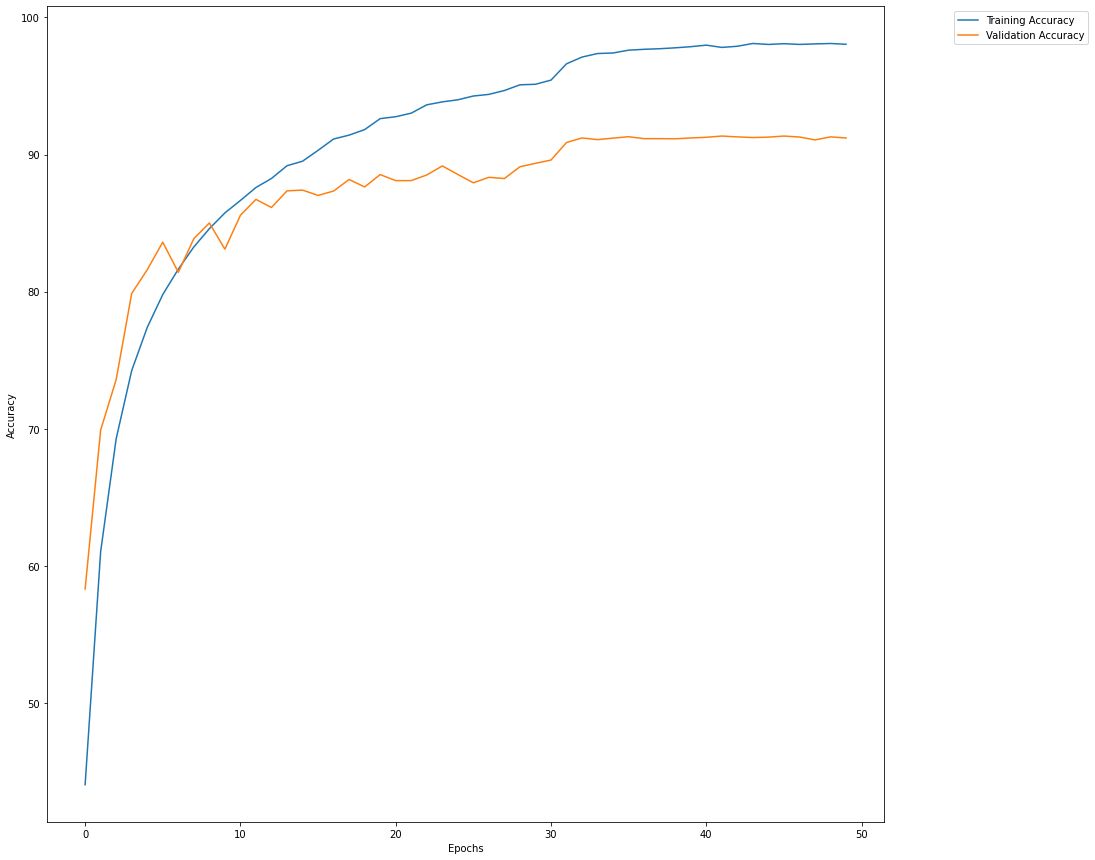

In [22]:
graphs.line_graph((15,15), train_accuracies, test_accuracies)


## Plotting 25 Misclassified Predictions

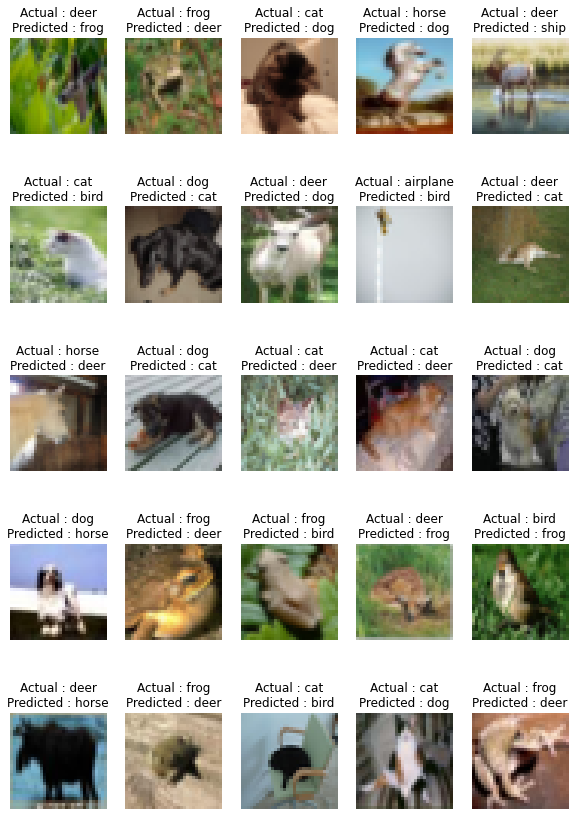

In [23]:
graphs.image_graph(5, 5, wrong_pred_data['Predicted'], wrong_pred_data['Actual'], wrong_pred_data['Images'])

## GradCAM

In [24]:
layers = [model.layer1,model.layer2,model.layer3,model.layer4]
GradCamView(wrong_pred_data,model,layers)

Output hidden; open in https://colab.research.google.com to view.